In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy
import math
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from collections import OrderedDict
import scipy.stats
import seaborn as sns
from IPython.display import Image
from pysal.esda.mapclassify import Natural_Breaks as nb

from mpl_toolkits.basemap import Polygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from random import randint
from mpl_toolkits.basemap import Basemap
import palettable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LogNorm, SymLogNorm, DivergingNorm

import matplotlib as mpl
from pysal.esda.mapclassify import Equal_Interval, User_Defined

import string

import geopandas as gpd
import psycopg2
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *

/home/denadai/.local/share/virtualenvs/crime-environment-u9RldRjF/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)
/home/denadai/.local/share/virtualenvs/crime-environment-u9RldRjF/lib/python3.6/site-packages/numba/decorators.py:33: NumbaDeprecationWarning: autojit is deprecated, use jit instead, which provides the same functionality. For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-numba-autojit
  warnings.warn(NumbaDeprecationWarning(msg))


In [9]:
sns.set(style="white")
sns.set_context("paper")

def figsize(scale,ratio, fig_width_pt = 505.69): # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    if(ratio == "golden"):                          # Golden ratio ...
        fig_height = fig_width*golden_mean          # height in inches
    else:                                           # ... or other ratio
        fig_height = fig_width*ratio
        
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {'backend': 'pdf',
                                            'axes.labelsize': 8,
                                            'xtick.labelsize': 8,
                                            'ytick.labelsize': 8,
                                            'legend.fontsize': 8,
                                            'lines.markersize': 3,
                                            'font.size': 8,
                                            'font.family': u'sans-serif',
                                            'font.sans-serif': ['Arial'],
                                            'text.usetex': False}
matplotlib.rcParams.update(pgf_with_latex)

In [10]:
import yaml

with open('../config/postgres.yaml') as f:
    engine_configs = yaml.load(f, Loader=yaml.FullLoader)
    
try:
    engine = create_engine('postgresql://{username}:{password}@{host}:{port}/{dbname}'.format(**engine_configs))
except Exception as e:
    print("Uh oh, can't connect. Invalid dbname, user or password?")
    print(e)

In [170]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def median_absolute_p_error(y_true, y_pred):
	return np.median(np.abs(100 * (y_pred - y_true) / y_true))

def mean_absolute_p_error(y_true, y_pred):
	return np.mean(np.abs(100 * (y_pred - y_true) / y_true))


In [171]:
from sklearn import preprocessing

def make_model_name(city, model_type, iterations=15000, dependent='ncrimes', spatial_name='ego'):
    model_name = '{city}_{spatial_name}_{name}_{iterations}_{dependent}'.format(iterations=iterations,
                                                                                city=city,
                                                                                name=model_type,
                                                                                dependent=dependent,
                                                                                spatial_name=spatial_name)
    return model_name

def load_data_for_maps(city, model_type, trend=True):
    # Predictions
    pred_df = pd.read_csv('../data/generated_files/model_predictions/pystan_BSF_{}.csv'.format(make_model_name(city, model_type)))
    #pred_df = pred_df.sort_values(['sp_id'])
    
    pred = pred_df['y_pred_full'].values
    if trend:
        pred = pred_df['y_pred'].values
        
    return np.floor(pred_df['y'].values+1), np.floor(pred+1) , pred_df['sp_id'].values

In [172]:
a = pd.read_csv('../data/generated_files/model_predictions/pystan_BSF_{}.csv'.format(make_model_name('bogota', 'full')))
a.head()

,sp_id,y,y_pred_full,y_pred,randomE
0,348085,125,88.0,58.0,30.0
1,348086,26,39.0,43.0,-4.0
2,348087,54,71.0,64.0,7.0
3,348088,47,53.0,48.0,5.0
4,348089,50,44.0,48.0,-4.0


In [173]:
## Create boundary shapefiles
sql = "SELECT city, geom FROM boundary ORDER BY city"

bounds_df = gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom')
bounds_df.head()

,city,geom
0,bogota,"MULTIPOLYGON (((-74.12742 4.47120, -74.12799 4..."
1,bogota1m,"MULTIPOLYGON (((-74.12742 4.47120, -74.12799 4..."
2,boston,"MULTIPOLYGON (((-71.12655 42.37162, -71.12655 ..."
3,boston1m,"MULTIPOLYGON (((-71.12655 42.37162, -71.12655 ..."
4,chicago,"MULTIPOLYGON (((-87.52978 41.74055, -87.52979 ..."


In [174]:
for c in set(bounds_df['city'].values):
    tmp_df = bounds_df[bounds_df['city'] == c]
    tmp_df.to_file("../data/generated_files/shps/boundary_{}.shp".format(c))

In [175]:
## Create spatial_group shapefiles
sql = "SELECT sp_id::text as sp_id, city, core_geom FROM spatial_groups ORDER BY city, sp_id::text"

spatial_groups_df = gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='core_geom')
spatial_groups_df.head()

,sp_id,city,core_geom
0,348085,bogota,"MULTIPOLYGON (((-74.17498 4.63674, -74.17298 4..."
1,348086,bogota,"MULTIPOLYGON (((-74.17828 4.64850, -74.17771 4..."
2,348087,bogota,"MULTIPOLYGON (((-74.17213 4.63790, -74.17549 4..."
3,348088,bogota,"MULTIPOLYGON (((-74.17617 4.63847, -74.17599 4..."
4,348089,bogota,"MULTIPOLYGON (((-74.17042 4.64452, -74.17068 4..."


In [176]:
for c in set(spatial_groups_df['city'].values):
    tmp_df = spatial_groups_df[spatial_groups_df['city'] == c]
    tmp_df.to_file("../data/generated_files/shps/spatial_groups_{}.shp".format(c))

In [177]:
cities_nice_names = {
    'boston': 'Boston',
    'bogota': 'Bogotá',
    'LA': 'Los Angeles',
    'chicago': 'Chicago'
}


## Maps

In [178]:
import math
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable


def roundup(x):
    return round(x / 100) * 100

def draw_choropleth_sp_ids(m, data, sp_ids, color, fieldname, ax =None, map_boundary=False):
    data_dict = {str(s): d for s, d in zip(sp_ids, data)}
    
    for info, shape in zip(getattr(m, '{}_info'.format(fieldname)), getattr(m, fieldname)):
        try:
            key = str(info[fieldname])
            unemployment_rate = data_dict[key]
        except KeyError:
            print("WARNING: key {} not found".format(key))
            # fix for not available data:
            ax.add_patch(Polygon(np.array(shape), facecolor=([241/255.,241/255.,241/255.]), edgecolor=(0,0,0,0), linewidth=0.5))
            continue
        ax.add_patch(Polygon(np.array(shape), facecolor=color(unemployment_rate), edgecolor=(255/255.,255/255.,255/255.), linewidth=0.1))    #'#C3C3C3'
    
    if not map_boundary:
        m.drawmapboundary(color='none')
    else:
        m.drawmapboundary(linewidth=0.3, color=np.array([42,42,42])/255.)
    
    return ax
    
def plot_seq_map(data, sp_ids, city, bounds, title, ax, color_cmap, norm, colorbar=False, low_high_legend=False, colorbar_title='Number of crimes', map_boundary=False, background=True, num_ticks=5, 
                 colorbar_digits=0, colorbar_logged=True):
    transformed_data = data[:]
    
    sw_bound, ne_bound = bounds
    m = Basemap(resolution='h', 
                llcrnrlon=sw_bound[0], 
                llcrnrlat=sw_bound[1], 
                urcrnrlon=ne_bound[0], 
                urcrnrlat=ne_bound[1],
                projection='lcc',
                # Center
                lat_0=(sw_bound[1]+ne_bound[1])/2,
                lon_0=(sw_bound[0]+ne_bound[0])/2,
                ax=ax)
    
    if background:
        water_color = np.array((173, 230, 252))/255
        continent_color = np.array([230, 228, 224, 180])/255
        m.fillcontinents(color=continent_color, lake_color=water_color)
        m.drawcoastlines(linewidth=0.25, color=np.array([42,42,42, 210])/255.)
        m.drawrivers(color=water_color)
        m.drawmapboundary(fill_color=water_color)

    m.readshapefile('../data/generated_files/shps/boundary_{}'.format(city), 'city', drawbounds=True, linewidth=0.5, color=np.array([150,150,150])/255.)
    m.readshapefile('../data/generated_files/shps/spatial_groups_{}'.format(city), 'sp_id', drawbounds=False, linewidth=0.5, color=np.array([200,200,200])/255.)
    ax.set_title(title)
    
    color = lambda x: color_cmap(norm(x))
    draw_choropleth_sp_ids(m, transformed_data, sp_ids, color, 'sp_id', ax, map_boundary)
    
    # Colorbar
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="2%", pad=0.25)
        
        add_continuos_colorbar(data, ax, color_cmap, norm, colorbar_title, 
                               low_high_legend=low_high_legend, num_ticks=num_ticks, 
                               digits=colorbar_digits, 
                                   logged=colorbar_logged,
                              cax=cax)
    

    
def plot_div_map(data, sp_ids, city, bounds, title, ax, color_cmap, norm, colorbar=False, low_high_legend=False, map_boundary=False, background=True, num_ticks=5, 
                 colorbar_title="Residual error", colorbar_digits=0, colorbar_logged=True):
    transformed_data = data
    
    sw_bound, ne_bound = bounds
    m = Basemap(resolution='h', 
                llcrnrlon=sw_bound[0], 
                llcrnrlat=sw_bound[1], 
                urcrnrlon=ne_bound[0], 
                urcrnrlat=ne_bound[1],
                projection='lcc',
                # Center
                lat_0=(sw_bound[1]+ne_bound[1])/2,
                lon_0=(sw_bound[0]+ne_bound[0])/2,
                ax=ax)
    
    if background:
        water_color = np.array((173, 230, 252))/255
        continent_color = np.array([240, 240, 240])/255
    
        m.drawmapboundary(fill_color=water_color)
        m.fillcontinents(color=continent_color, lake_color=water_color)

        m.drawcoastlines(linewidth=0.25, color=np.array([42,42,42, 210])/255., zorder=-1)
        m.drawrivers(color=water_color)
    
    m.readshapefile('../data/generated_files/shps/boundary_{}'.format(city), 'city', drawbounds=True, linewidth=0.5, color=np.array([150,150,150])/255.)
    m.readshapefile('../data/generated_files/shps/spatial_groups_{}'.format(city), 'sp_id', drawbounds=False, linewidth=0.5, color=np.array([200,200,200])/255.)
    ax.set_title(title)
    
    color = lambda x: color_cmap(norm(x))
    draw_choropleth_sp_ids(m, transformed_data, sp_ids, color, 'sp_id', ax, map_boundary)
    
    # Colorbar
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="2%", pad=0.25)

        add_continuos_colorbar(data, ax, color_cmap, norm, 
                               colorbar_title=colorbar_title, 
                               low_high_legend=low_high_legend, 
                               isdivergent=True, 
                               num_ticks=num_ticks,
                               digits=colorbar_digits, 
                               logged=colorbar_logged,
                              cax=cax)
    

def plot_map_strata(data, sp_ids, bounds, title, ax, color_cmap, gbreaks, map_boundary=False, background=True):
    
    num_colors = len(color_cmap)
    breaks = User_Defined(data, bins=[1,2,3,4,5,6])
    print(breaks)
    
    discrete_data = breaks.yb
    
    gbreaks = breaks.yb
    
    sw_bound, ne_bound = bounds
    
    m = Basemap(resolution='h', 
                llcrnrlon=sw_bound[0], 
                llcrnrlat=sw_bound[1], 
                urcrnrlon=ne_bound[0], 
                urcrnrlat=ne_bound[1],
                projection='lcc',
                # Center
                lat_0=(sw_bound[1]+ne_bound[1])/2,
                lon_0=(sw_bound[0]+ne_bound[0])/2,
                ax=ax)
    
    if background:
        water_color = np.array((173, 230, 252))/255
        continent_color = np.array([230, 228, 224, 180])/255
    
        m.fillcontinents(color=continent_color, lake_color=water_color)

        m.drawcoastlines(linewidth=0.25, color=np.array([42,42,42, 210])/255.)
        m.drawrivers(color=water_color)
        m.drawmapboundary(fill_color=water_color)

    m.readshapefile('../data/generated_files/shps/spatial_groups_bogota', 'sp_id', drawbounds=True, linewidth=0.2, color=np.array([42,42,42])/255.)
    ax.set_title(title)
    
    # Natural breaks
    c = ListedColormap(color_cmap)
    norm = plt.Normalize(vmin=min(discrete_data), vmax=max(discrete_data))
    color = lambda x: c(norm(x))
    draw_choropleth_sp_ids(m, discrete_data, sp_ids, color, 'sp_id', ax, map_boundary)
    
    mappable = plt.cm.ScalarMappable(cmap=c)
    mappable.set_array([])
    mappable.set_clim(0, num_colors)
    cbar = plt.colorbar(mappable, orientation='horizontal', shrink=0.9, aspect=20, fraction=0.05, pad=0.05, ax=ax)
    cbar.set_ticks(np.arange(0, num_colors+1))
    
    colorbar_title = 'Level'
    labels = ['' for x in range(num_colors+1)]
    labels[0] = 'Low'
    labels[-1] = 'High'
    labels = [0] + [int(x) for x in (breaks.bins)]
    cbar.ax.set_title(colorbar_title)
    cbar.set_ticklabels(labels)
    
    cbar.outline.set_edgecolor('#C3C3C3')
    cbar.outline.set_linewidth(0.5)
    
def plot_OD_map(discrete_data, coords, OD_matrix, row_sums, sp_ids, city, bounds, title, ax, color_cmap, node_colors, colobarbar=False, low_high_legend=False, colorbar_title='Number of crimes', map_boundary=False, background=True):
    num_colors = len(color_cmap)
    
    sw_bound, ne_bound = bounds
    m = Basemap(resolution='h', 
                llcrnrlon=sw_bound[0], 
                llcrnrlat=sw_bound[1], 
                urcrnrlon=ne_bound[0], 
                urcrnrlat=ne_bound[1],
                projection='lcc',
                # Center
                lat_0=(sw_bound[1]+ne_bound[1])/2,
                lon_0=(sw_bound[0]+ne_bound[0])/2,
                ax=ax)
    
    if background:
        water_color = np.array((173, 230, 252))/255
        continent_color = np.array([230, 228, 224, 180])/255
    
        m.fillcontinents(color=continent_color, lake_color=water_color)

        m.drawcoastlines(linewidth=0.25, color=np.array([42,42,42, 210])/255.)
        m.drawrivers(color=water_color)
        m.drawmapboundary(fill_color=water_color)

    m.readshapefile('../data/generated_files/shps/spatial_groups_{}'.format(city), 'sp_id', drawbounds=True, linewidth=0.2, color=np.array([42,42,42])/255., zorder=1)
    ax.set_title(title)
    
    if not map_boundary:
        m.drawmapboundary(color='none')
    else:
        m.drawmapboundary(linewidth=0.3, color=np.array([42,42,42])/255.)
    
    # Colorbar
    c = ListedColormap(color_cmap)
    norm = plt.Normalize(vmin=min(discrete_data), vmax=max(discrete_data))
    color = lambda x: c(norm(x))
    
    G=nx.Graph()
    pos={}
    node_labels = {}
    node_sizes = []
    node_color_list = []
    
    rows_sums_dict = defaultdict(int)
    for i, tot in row_sums[['o_sp_id', 'tot']].values:
        rows_sums_dict[i] = tot
        
    for n, x, y in coords:
        G.add_node(n)
        pos[n] = m(x, y)
        node_labels[n] = ""
        node_color_list.append(node_colors[n])
        node_sizes.append(rows_sums_dict[n]*250+30)

    edge_color = []
    for a,b in OD_matrix:
        G.add_edge(a, b)
        edge_color.append(node_colors[a])

    # draw
    nodes = nx.draw_networkx_nodes(G, pos, node_color = node_color_list, node_size=node_sizes, linewidths=1)
    nodes.set_edgecolor([0, 0, 0])
    nx.draw_networkx_edges(G, pos=pos, alpha=0.6, edge_color = edge_color)
    
    

    mappable = plt.cm.ScalarMappable(cmap=c)
    mappable.set_array([])
    mappable.set_clim(0, num_colors)
    cbar = plt.colorbar(mappable, orientation='horizontal', shrink=0.6, aspect=20, fraction=0.05, pad=0.05, ax=ax)
    cbar.set_ticks(np.arange(0, num_colors+1))

    labels = ['' for x in range(num_colors+1)]
    labels[0] = 'Low'
    labels[-1] = 'High'
    cbar.ax.set_title(colorbar_title)
    cbar.set_ticklabels(labels)

    cbar.outline.set_edgecolor('#C3C3C3')
    cbar.outline.set_linewidth(0.5)
    
def create_bins(city, models_name, k, error_bins=False):
    ys = []
    ys_pred = []
    
    for m in models_name:
        y, y_pred, _ = load_data_for_maps(city, m)
        ys.extend(y.tolist())
        ys_pred.extend(y_pred.tolist())
    
    # Creates the same bins for all the models
    if error_bins:
        ys_pred = (np.array(ys)-np.array(ys_pred)).tolist()
    bins = nb(ys_pred, k=k).bins.tolist()
    return bins

def create_norm(city, models_name, k, error_bins=False, norm_method=plt.Normalize):
    ys = []
    ys_pred = []
    
    for m in models_name:
        y, y_pred, _ = load_data_for_maps(city, m)
        ys.extend(y.tolist())
        ys_pred.extend(y_pred.tolist())
        
    ys = np.array(ys)
    ys_pred = np.array(ys_pred)
    
    # Creates the same bins for all the models
    if error_bins:
        ys_pred = ys_pred-ys
        
    if norm_method.__name__ == 'LogNorm':
        ys_pred = ys_pred 
        ys = ys 
    elif norm_method.__name__ == 'SymLogNorm':
        return norm_method(vmin=math.floor(min(ys_pred)), vmax=math.floor(max(ys_pred)), linthresh=10)
    elif norm_method.__name__ == 'DivergingNorm':
        return norm_method(vmin=math.floor(min(ys_pred)), vmax=math.floor(max(ys_pred)), vcenter=0)
    
    norm = norm_method(vmin=math.floor(min(ys_pred)), vmax=math.floor(max(ys_pred)))
    return norm


def add_continuos_colorbar(data, ax, cmap, norm, colorbar_title, low_high_legend=False, shrink=0.9, num_ticks=5, 
                           isdivergent=False, scale_factor=None, cax=None, underling_data=None,
                          low_label='Low', high_label='High', zerostart=True, logged=True, digits=0):
    
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])

    labels = ['' for x in range(num_ticks)]
    labels[0] = low_label
    labels[-1] = high_label
    ticks = [norm.vmin, norm.vmax]
    if not low_high_legend:
        ticks = np.linspace(norm.vmin, norm.vmax, num=num_ticks, endpoint=True)
        labels = ticks[:]
        if not isdivergent:
            ticks = np.linspace(norm.vmin, norm.vmax, num=num_ticks, endpoint=True)
            labels = ticks[:]
            if logged:
                ticks = np.logspace(np.log10(norm.vmin), np.log10(norm.vmax), num=num_ticks, endpoint=True)
                
        elif isdivergent and logged:
            maxlog=np.log10(int(np.ceil( norm.vmax) ))
            minlog=np.log10(int(np.ceil( -norm.vmin) ))
            #print(minlog, maxlog, 10**minlog, 10**maxlog)
            
            left_l_ticks = (-10**np.linspace(minlog, 0, num=4, endpoint=True)).astype(int).tolist()[:-1]
            #right_l_ricks = (10**np.linspace(0, maxlog, num=3, endpoint=True)).astype(int).tolist()[1:]
            right_l_ricks = (-1*np.array(left_l_ticks)).astype(int).tolist()
            ticks = ( left_l_ticks
                  + [0.0]
                  + right_l_ricks)
            #print("e", ticks)
            ticks = np.array(ticks)
            ticks = ticks[ticks!=1.0]
            ticks = ticks[ticks!=-1.0]
            
            
            
        elif isdivergent and not logged:
            max_n = max(abs(norm.vmin), abs(norm.vmax))
            ticks = np.linspace(-max_n, 0, num=2, endpoint=False).tolist() + [0] + np.linspace(0, max_n, num=3, endpoint=True).tolist()[1:]
            ticks = np.array(ticks)
    
    labels = np.floor(np.array(ticks[:])).astype(int)
    if digits > 0:
        labels = np.round(np.array(ticks[:]), digits)
    
    if not isdivergent and zerostart:
        labels[0] = 0
            
    cbar = plt.colorbar(mappable, orientation='horizontal', shrink=shrink, 
                        aspect=20, fraction=0.05, pad=0.2, ax=ax, cax=cax,
                       ticks=ticks
                       )
    cbar.ax.set_title(colorbar_title)
    cbar.set_ticklabels(labels)
    
    cbar.outline.set_visible(False)
    return cbar

In [179]:
bounds = {
    'bogota': [
        (-74.22342, 4.46626), #lower left
        (-74.00959, 4.83300)
    ],
    'boston': [
        (-71.19084, 42.22784), #lower left
        (-70.98626, 42.39694)
    ],
    'LA': [
        (-118.66816, 33.70403), #lower left
        (-118.15529, 34.33791)
    ],
    'chicago': [
        (-87.94011, 41.64454), #lower left
        (-87.52409, 42.02302)
    ]
}

nice_names_mapping = {
    'core_walkscore': 'Walkscore',
    'disadvantage': 'Disadvantage',
    'core_ambient': 'Ambient population',
    'core_shops': 'Shops',
}

color_map_seq = palettable.colorbrewer.sequential.OrRd_4.mpl_colors
cmap_seq = palettable.colorbrewer.sequential.OrRd_4.mpl_colormap
n_colors_seq = len(color_map_seq)

color_map_div = palettable.colorbrewer.diverging.RdBu_7.mpl_colors
color_map_div.reverse()
n_colors_div = len(color_map_div)
cmap_div = palettable.colorbrewer.diverging.RdBu_7.mpl_colormap.reversed()
cmap_improvement = palettable.colorbrewer.diverging.PiYG_7.mpl_colormap

color_map_div_detailed = palettable.colorbrewer.diverging.RdBu_9.mpl_colors
color_map_div_detailed.reverse()
n_colors_div_detailed = len(color_map_div_detailed)

SUPPLEMENTARY_PT = 418.2555

## Maps Prediction

In [180]:
def collect_predictions(city, models_name):
    y = None
    y_pred = {}
    sp_ids = None
    for m in models_name:
        y, y_pred[m], sp_ids = load_data_for_maps(city, m)
    return y, y_pred, sp_ids

def make_sequential_map(city, models_to_show, figsize, bounds, nodiv=True, extension='png', save=True):
    # Creates the same bins for all the models
    norm = create_norm(city, models_to_show, k=n_colors_seq, norm_method=LogNorm)

    # Collect predictions
    y, y_pred, sp_ids = collect_predictions(city, models_to_show)

    f, axs = plt.subplots(1, len(models_to_show) + (1 if nodiv else 2), sharey = True, figsize=figsize)
    for i, m in enumerate(models_to_show):
        title = 'Social-disorganization (SD)'
        if m == 'uf':
            title = 'Built environment (BE)'
        elif m == 'full':
            title = 'SD+BE+Mobility (Full)'
        elif m == 'sd_uf':
            title = 'SD+BE'
        plot_seq_map(y_pred[m], sp_ids, city, bounds[city], title, axs[i], cmap_seq, norm, background=False, map_boundary=False)
    
    plot_seq_map(y, sp_ids, city, bounds[city], 'Ground truth', axs[len(models_to_show)], cmap_seq, norm, background=False, map_boundary=False)
    if not nodiv:
        residuals = (y_pred[models_to_show[-1]]-y)
        norm = SymLogNorm(vmin=residuals.min(), vmax=residuals.max(), linthresh=10)
        plot_div_map(residuals, sp_ids, city, bounds[city], 'Full model\'s residuals', axs[4], cmap_div, norm, colobarbar=True, background=False, map_boundary=False)

    for n, ax in enumerate(axs):
        ax.text(0.04, 0.04, string.ascii_uppercase[n]+')', transform=ax.transAxes, size=13, weight='bold')

    plt.tight_layout()
    if save:
        plt.savefig('../figures/manuscript/{}_maps.{}'.format(city, extension), format=extension, bbox_inches='tight', pad_inches=0.05)
    


def make_divergent_map(city, models_to_show, figsize, bounds, extension='png', save=True):
    # Creates the same bins for all the models
    norm = create_norm(city, models_to_show, k=n_colors_seq, error_bins=True, norm_method=SymLogNorm) #norm_method=SymLogNorm
    
    # Collect predictions
    y, y_pred, sp_ids = collect_predictions(city, models_to_show)
    
    f, axs = plt.subplots(1, len(models_to_show), sharey = True, figsize=figsize)
    for i, m in enumerate(models_to_show):
        title = 'Social-disorganization (SD)'
        if m == 'uf':
            title = 'Built environment (BE)'
        elif m == 'm':
            title = 'Mobility (M)'
        elif m == 'full':
            title = 'SD+BE+M'
        elif m == 'sd_uf':
            title = 'SD+BE'
        elif m == 'core':
            title = 'Core only'
        plot_div_map(y_pred[m]-y, sp_ids, city, bounds[city], title, axs[i], cmap_div, norm, map_boundary=True)
    
    # Colormap
    errors = [a-b for a,b in zip(y_pred[models_to_show[0]], y)]
    #print(errors_labels)
    cbar_ax = f.add_axes([0.25, 0.28, 0.5, 0.01])
    add_continuos_colorbar(errors, cbar_ax, cmap_div, norm, colorbar_title="Residual error (from under- to over-estimate)", num_ticks=7, cax=cbar_ax, isdivergent=True)
    plt.suptitle('Residuals of the Bogota\'s models', y=0.71)

    for n, (ax, m) in enumerate(zip(axs, models_to_show)):
        ax.text(0.04, 0.04, string.ascii_uppercase[n]+')', transform=ax.transAxes, size=13, weight='bold')
        ax.text(.5,-0.1, 'Residuals: [{}, {}]'.format(int((y_pred[m]-y).min()), int((y_pred[m]-y).max())), horizontalalignment='center', transform=ax.transAxes, size=10)

    plt.tight_layout()
    if save:
        plt.savefig('../figures/manuscript/{}_residuals_maps.{}'.format(city, extension), format=extension, bbox_inches='tight', pad_inches=0.05)

In [181]:
import hashlib
import os
import pickle
from mpl_toolkits.axes_grid1 import AxesGrid


def load_eigenfactors(city, model_name, n_factors=4):
    
    # Load phi
    with open('../data/generated_files/pkl/{spatial_model}_{model_name}.pkl'.format(spatial_model='BSF', model_name=model_name), "rb") as f:
        fit = pickle.load(f)['fit']
        la = fit.extract(permuted=False, inc_warmup=False, pars=['phi'])
        phi = la['phi']
    
    # Load W
    cache_name = '../cache/{city}_ego_W.npz'.format(city=city)
    W = np.load(cache_name)['W']
    
    N = len(W)

    ones = np.ones((N, 1), dtype='float32')
    P_t = np.identity(N, dtype='float32') - ones.dot(ones.T)/N
    M = P_t.dot(W).dot(P_t)

    v, E = np.linalg.eigh(M)
    sortid = v.argsort()[::-1]

    n_eigens_regression = phi.shape[-1]
    v = v[sortid][:n_eigens_regression]
    E = E[:, sortid][:, :n_eigens_regression]
    
    mc_e = (N/(ones.T.dot(W).dot(ones))*v)
    
    phi = la['phi'][:, 0, :].mean(0)
    
    E_tot = (E*phi).sum(1)
    mc_e_tot = mc_e.sum(1)
    
    E_firstn = E[:, :n_factors]*phi[:n_factors]
    mc_e_firstn = mc_e[:, :n_factors]
    
    return E_tot, E_firstn, phi[:n_factors], n_eigens_regression #mc_e_firstn[0]

## Main figure

In [182]:
def make_create_main_figure(city, models_to_show, figsize, bounds, extension='png', save=True):
    # Creates the same bins for all the models
    #norm = create_norm(city, models_to_show, k=n_colors_seq, norm_method=DivergingNorm)
    
    y, baseline_pred, sp_ids = collect_predictions(city, ['core'])
    e = np.abs(baseline_pred['core']-y)
    
    baseline_pred = baseline_pred['core']

    # Collect predictions
    y, y_pred, sp_ids = collect_predictions(city, models_to_show)
    improvement = []
    for k,v in y_pred.items():
        e1 = np.abs(v-y)
        improvement.extend(((e-e1)).tolist())
        
    maxnum_colorbar = max(np.abs(np.min(improvement)), np.max(improvement))
    norm = SymLogNorm(vmin=-maxnum_colorbar, vmax=maxnum_colorbar, linthresh=20)
    
    f, axs = plt.subplots(1, len(models_to_show) + 2, sharey = True, figsize=figsize)
    f.tight_layout()
    for i, m in enumerate(models_to_show):
        title = 'Social-disorganization (SD)'
        if m == 'uf':
            title = 'Built environment (BE)'
        if m == 'm':
            title = "Mobility (M)"
        elif m == 'full':
            title = 'SD+BE+M (Full)'
        elif m == 'sd_uf':
            title = 'SD+BE'
        e1 = np.abs(y_pred[m]-y)
        temp = (e-e1)
        plot_div_map(temp, sp_ids, city, bounds[city], title, axs[i], cmap_improvement, norm, background=False, map_boundary=False,
                    colorbar=True, colorbar_title="Absolute error improvement")
    
    y, y_pred, sp_ids = load_data_for_maps(city, models_to_show[-1], trend=False)
    # Shared norm GT vs Prediction
    norm = LogNorm(vmin=1, vmax=math.floor(max(np.max(y), np.max(y_pred))))
    plot_seq_map(y_pred, sp_ids, city, bounds[city], 'Prediction (Full)', axs[-2], cmap_seq, norm, colorbar=True, background=False, map_boundary=False)
    plot_seq_map(y, sp_ids, city, bounds[city], 'Ground truth', axs[-1], cmap_seq, norm, colorbar=True, background=False, map_boundary=False)
    
    for n, ax in enumerate(axs):
        ax.text(0.04, 0.04, string.ascii_uppercase[n]+')', transform=ax.transAxes, size=13, weight='bold')
    
    plt.savefig('../figures/manuscript/main_maps.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)

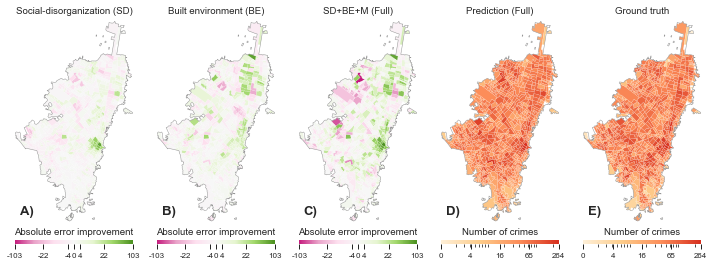

In [183]:
make_create_main_figure(city='bogota', models_to_show=['sd', 'uf', 'full'], figsize=figsize(1.45, 0.75), bounds=bounds, extension='pdf')

In [184]:
def make_supplementary_maps(city, models_to_show, figsize, bounds, extension='png', save=True):
    # Creates the same bins for all the models
    #norm = create_norm(city, models_to_show, k=n_colors_seq, norm_method=DivergingNorm)
    
    y, baseline_pred, sp_ids = collect_predictions(city, ['core'])
    e = np.abs(baseline_pred['core']-y)
    baseline_pred = baseline_pred['core']

    # Collect predictions
    y, y_pred, sp_ids = collect_predictions(city, models_to_show)
    improvement = []
    for k,v in y_pred.items():
        e1 = np.abs(v-y)
        improvement.extend((e-e1).tolist())
        
    max_improvement = max(np.abs(improvement))
    print(max_improvement)
    norm = SymLogNorm(vmin=-max_improvement, vmax=np.floor(np.max(max_improvement)), linthresh=5)
    #norm = DivergingNorm(vmin=np.min(improvement), vmax=np.max(improvement), vcenter=0)
    
    f, axs = plt.subplots(2, len(models_to_show), sharey = True, figsize=figsize)
    f.tight_layout()
    for i, m in enumerate(models_to_show):
        title = 'Social-disorganization (SD)'
        if m == 'uf':
            title = 'Built environment (BE)'
        if m == 'm':
            title = "Mobility (M)"
        elif m == 'full':
            title = 'SD+BE+M (Full)'
        elif m == 'sd_uf':
            title = 'SD+BE'
        e1 = np.abs(y_pred[m]-y)
        temp = (e-e1)
        plot_div_map(temp, sp_ids, city, bounds[city], title, axs[0, i], cmap_improvement, norm, background=False, map_boundary=False,
                    colorbar=True, colorbar_title="Error improvement")
        
    ## Features
    feats = ['disadvantage', 'core_walkscore', 'core_shops']
    if city != 'chicago':
        feats.append('core_ambient')
    census_df = pd.read_csv('../data/generated_files/merged_features.csv')
    data = census_df[census_df.city==city].sort_values(['sp_id'])[feats + ['sp_id']]
    
    for i, f in enumerate(feats):
        norm = plt.Normalize(vmin=min(data[f].values), vmax=max(data[f].values))

        plot_seq_map(data[f].values, data['sp_id'].values, city, bounds[city], nice_names_mapping[f], axs[1, i], cmap_seq, norm, 
                     background=False, map_boundary=False, colorbar=True, colorbar_logged=False, colorbar_digits=2,
                    colorbar_title='')

    for n, ax in enumerate(axs.ravel()):
        ax.text(0.04, 0.04, string.ascii_uppercase[n]+')', transform=ax.transAxes, size=13, weight='bold')
        
    plt.savefig('../figures/manuscript/supplementary/{cityname}_improvement.{extension}'.format(cityname=city, extension=extension), format=extension, bbox_inches='tight', pad_inches=0.05, dpi=150)
    

105.0


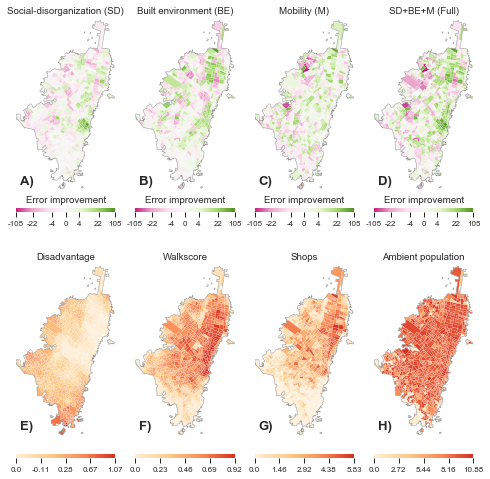

In [185]:
make_supplementary_maps(city='bogota', models_to_show=['sd', 'uf', 'm', 'full'], figsize=figsize(1.2, 1.0, SUPPLEMENTARY_PT), bounds=bounds, extension='png')

49.0


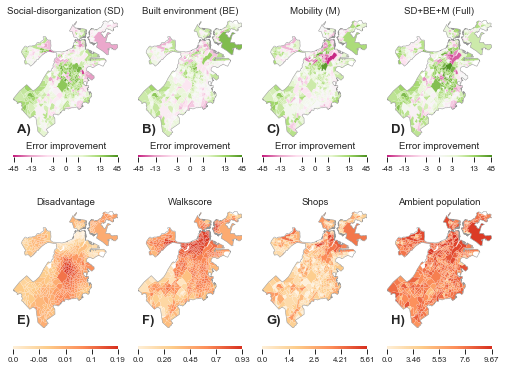

In [186]:
#new zero
make_supplementary_maps(city='boston', models_to_show=['sd', 'uf', 'm', 'full'], figsize=figsize(1.25, 0.75, SUPPLEMENTARY_PT), bounds=bounds, extension='png')

127.0


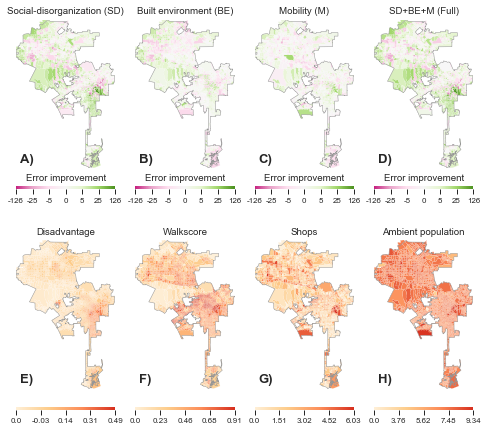

In [187]:
make_supplementary_maps(city='LA', models_to_show=['sd', 'uf', 'm', 'full'], figsize=figsize(1.2, 0.9, SUPPLEMENTARY_PT), bounds=bounds, extension='png')

134.0


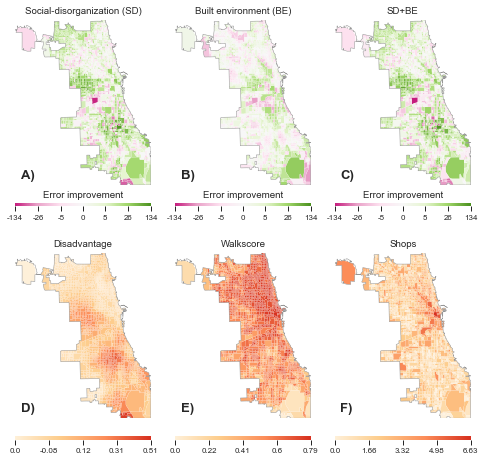

In [188]:
make_supplementary_maps(city='chicago', models_to_show=['sd', 'uf', 'sd_uf'], figsize=figsize(1.2, 0.95, SUPPLEMENTARY_PT), bounds=bounds, extension='png')

## Eigendecomposition

In [189]:
def make_eigendecomposition_map(city, figsize, bounds, extension='png', save=True, model_to_show = 'full'):
    
    f, axs = plt.subplots(1, 4, sharey = True, figsize=figsize)
    f.tight_layout()
    
    if city == 'chicago':
        model_to_show = 'sd_uf'
    
    ## Plot GT + Prediction
    y, y_pred, sp_ids = load_data_for_maps(city, model_to_show, trend=True)
    # Shared norm GT vs Prediction
    norm = LogNorm(vmin=1, vmax=math.floor(max(np.max(y), np.max(y_pred))))
    plot_seq_map(y, sp_ids, city, bounds[city], 'Ground truth', axs[0], cmap_seq, norm, background=False, map_boundary=False, colorbar=True)
    plot_seq_map(y_pred, sp_ids, city, bounds[city], 'Fixed effects', axs[1], cmap_seq, norm, background=False, map_boundary=False, colorbar=True)
    
    
    y_trend = y_pred[:]
    y, y_pred, sp_ids = load_data_for_maps(city, model_to_show, trend=False)
    
    ## Plot Eigenmap
    _, _, _, n_eigens = load_eigenfactors(city,  make_model_name(city, model_to_show), n_factors=1)
    E = y_pred - y_trend
    
    cmax = max(abs(E.min()), abs(E.max()))
    norm = SymLogNorm(vmin=-cmax, vmax=cmax, linthresh=10)
    plot_div_map(E, sp_ids, city, bounds[city], 'Spatial Eigenvectors effects', axs[2], cmap_improvement, norm, 
                 background=False, map_boundary=False, 
                 colorbar=True, colorbar_logged=True, colorbar_title=r'$E_{{0-{}}}$'.format(n_eigens))
    
    ## Plot Residuals
    residuals = (y_pred-y)
    norm = SymLogNorm(vmin=residuals.min(), vmax=residuals.max(), linthresh=10)
    plot_div_map(residuals, sp_ids, city, bounds[city], 'Residuals', axs[3], cmap_div, norm, 
                 colorbar=True, background=False, map_boundary=False)

    for n, ax in enumerate(axs):
        ax.text(0.04, 0.04, string.ascii_uppercase[n]+')', transform=ax.transAxes, size=13, weight='bold')
    
    if save:
        plt.savefig('../figures/manuscript/supplementary/{cityname}_eigens.{extension}'.format(cityname=city, extension=extension), format=extension, bbox_inches='tight', pad_inches=0.05, dpi=150)


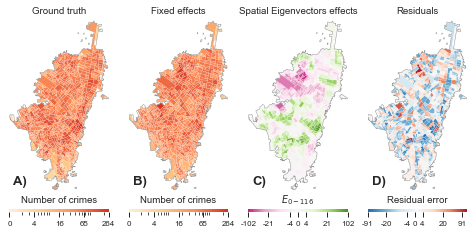

In [190]:
make_eigendecomposition_map(city='bogota', figsize=figsize(1.2, 1.25, SUPPLEMENTARY_PT), bounds=bounds, extension='png')

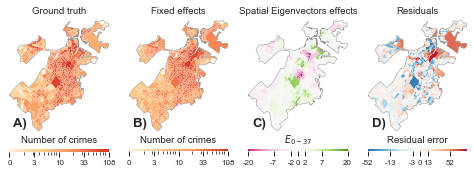

In [191]:
make_eigendecomposition_map(city='boston', figsize=figsize(1.2, 0.8, SUPPLEMENTARY_PT), bounds=bounds, extension='png')

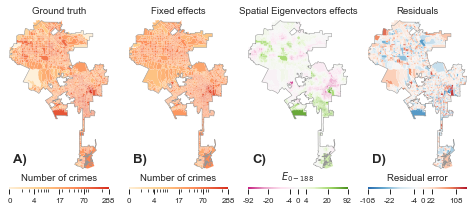

In [192]:
make_eigendecomposition_map(city='LA', figsize=figsize(1.2, 1.4, SUPPLEMENTARY_PT), bounds=bounds, extension='png')

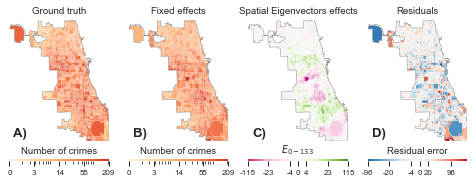

In [193]:
make_eigendecomposition_map(city='chicago', figsize=figsize(1.2, 1.4, SUPPLEMENTARY_PT), bounds=bounds, extension='png')

## Marta's maps

In [14]:
data_df = pd.read_csv('../data/generated_files/merged_features.csv')
data_df['sp_id'] = data_df['sp_id'].astype(str)

data_df = data_df.sort_values(['city', 'sp_id'])
data_df.head()

,sp_id,city,spatial_name,land_use_mix3,land_use_mix2,walkscore,core_walkscore,avg_block_area,n_blocks,sum_block_area,...,Arson,Burglary (breaking or entering),Criminal homicide,Motor vehicle theft,Rape,Robbery,ncrimes,disadvantage,residential_stability,small_blocks
5149,181963,LA,ego,0.711246,0.995054,0.431411,0.271692,9.879763,-3.490046,759.577076,...,0,12,0,7,0,2,22,-0.057363,0.297020,0.091914
4556,181964,LA,ego,0.324581,0.496285,0.576637,0.442002,10.003301,-3.824797,587.025972,...,0,10,0,3,0,0,14,-0.043512,-0.070415,0.090882
3921,181965,LA,ego,0.263234,0.472496,0.526915,0.502243,9.840906,-3.669718,945.302069,...,1,12,0,3,0,3,21,-0.031301,0.018948,0.092243
3070,181966,LA,ego,0.363468,0.596087,0.569559,0.628393,9.709909,-3.910386,1159.747167,...,0,12,0,2,0,7,22,-0.029151,-0.038889,0.093371
3569,181967,LA,ego,0.773234,0.984182,0.497871,0.588758,9.905465,-3.463240,1068.895438,...,0,5,0,4,0,1,17,0.072529,0.046129,0.091697


In [199]:
worst_colors = np.array([
        [214, 0, 6],
        [249, 141, 0],
        [53, 111, 165],
        [74, 151, 193],
        [0, 154, 71],
        [0, 95, 49],
    ])
worst_colors = worst_colors/255.

worst_colors_OD = np.array([
        [214, 0, 6],
        [53, 111, 165],
        [0, 95, 49],
    ])
worst_colors_OD = worst_colors_OD[::-1]/255.

In [200]:
import networkx as nx
import itertools
from collections import defaultdict


## Create spatial_group shapefiles
sql = "SELECT sp_id::text as sp_id, city, ST_X(ST_Centroid(approx_geom)) as lng, ST_Y(ST_Centroid(approx_geom)) as lat FROM spatial_groups ORDER BY city, sp_id::text"

coords_df = pd.read_sql_query(sql, engine)
coords_df.head()

,sp_id,city,lng,lat
0,1,bogota,-74.034560,4.800932
1,10,bogota,-74.032264,4.751423
2,100,bogota,-74.072637,4.643548
3,101,bogota,-74.073839,4.627966
4,102,bogota,-74.084457,4.610981


In [201]:
def fetch_OD_matrix(df_coords, cityname):
    all_sp_ids = list(set(df_coords.sp_id.values))
    tuples = list(itertools.product(all_sp_ids, all_sp_ids))

    # OD matrix
    df_OD = pd.read_csv('../data/generated_files/{}_ODs.csv'.format(cityname), dtype={'o_sp_id': str, 'd_sp_id':str}).drop('city', axis=1).melt('o_sp_id', var_name='d_sp_id', value_name='tot')
    df_OD2 = df_OD[df_OD.o_sp_id < df_OD.d_sp_id].copy()
    df_OD2 = df_OD2[df_OD2.o_sp_id.isin(set(df_coords.sp_id.values)) & df_OD2.d_sp_id.isin(set(df_coords.sp_id.values))]
    df_OD2 = df_OD2.set_index(['o_sp_id', 'd_sp_id']).reindex(tuples).fillna(0)
    df_OD = df_OD.set_index(['o_sp_id', 'd_sp_id']).reindex(tuples).fillna(0)
    for i, row in df_OD2.iterrows():
        if i[1] != i[0]:
            r = (i[1], i[0])
            df_OD2.loc[(i[0], i[1]), 'tot'] = df_OD.loc[r, 'tot'] + row['tot']

    df_OD2 = df_OD2.reset_index()
    df_OD2 = df_OD2[df_OD2.o_sp_id < df_OD2.d_sp_id]

    row_sums = df_OD2.groupby('o_sp_id', as_index=False).sum()
    row_sums.loc[:, 'tot'] = row_sums['tot']/row_sums['tot'].max()
    
    df_OD2 = df_OD2[df_OD2.tot > 0]
    
    return df_OD2, row_sums

/home/nadai/.local/share/virtualenvs/crime-environment-aZbKKJXb/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1668: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif fill_color == 'none' or fill_color == 'None':


             User Defined             
 
Lower          Upper             Count
        x[i] <= 1.000                2
1.000 < x[i] <= 2.000               27
2.000 < x[i] <= 3.000               51
3.000 < x[i] <= 4.000               18
4.000 < x[i] <= 5.000                7
5.000 < x[i] <= 6.000                5


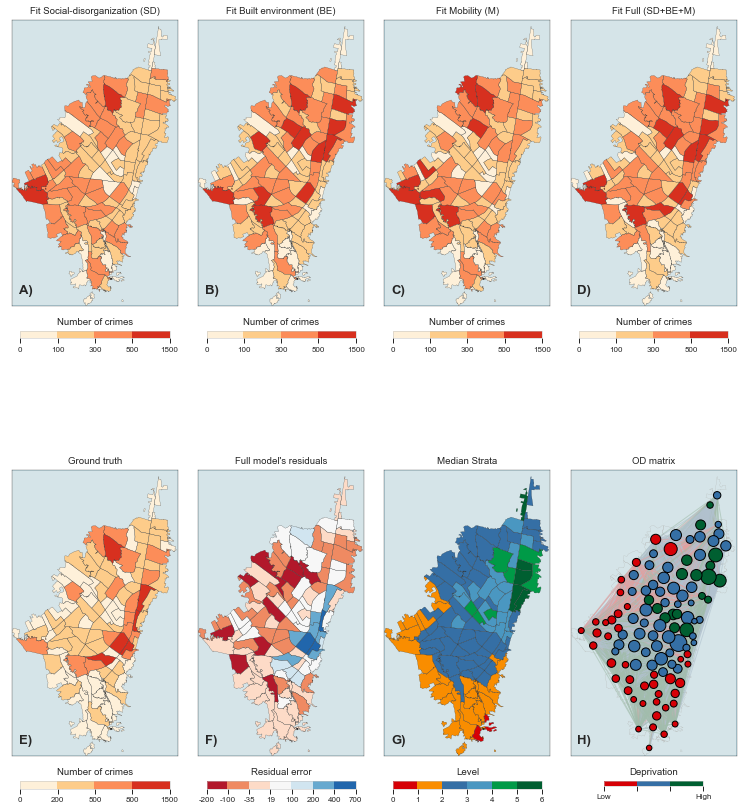

In [202]:
CITY = 'bogota'
data_df_city = data_df[(data_df.city == CITY) & (data_df.spatial_name == 'neigh')]
df_coords_city = coords_df[(coords_df.city == CITY) & (coords_df.sp_id.isin(data_df_city.sp_id))]
df_OD_city, row_sums = fetch_OD_matrix(df_coords_city, CITY)

# Creates the same bins for all the models
bins = create_bins(CITY, ['sd', 'uf', 'm', 'full'], ys_est, ys_true, k=n_colors_seq)

# Deprivation OD 
node_colors = {}
od_data = nb(data_df_city['median_income'], k=3).yb
gbreaks = nb(data_df_city['median_income'], k=6).yb
for n, w in zip(data_df_city['sp_id'], od_data):
    node_colors[str(n)] = worst_colors_OD[::-1][w]


f, axs = plt.subplots(2, 4, sharey = True, figsize=figsize(1.5, 1.3))

plot_seq_map(ys_est[(CITY, 'sd')], sp_ids[CITY], CITY, bounds[CITY], 'Fit Social-disorganization (SD)', axs[0, 0], color_map_seq, map_boundary=True, bins=bins)
plot_seq_map(ys_est[(CITY, 'uf')], sp_ids[CITY], CITY, bounds[CITY], 'Fit Built environment (BE)', axs[0, 1], color_map_seq, map_boundary=True, bins=bins)
plot_seq_map(ys_est[(CITY, 'm')], sp_ids[CITY], CITY, bounds[CITY], 'Fit Mobility (M)', axs[0, 2], color_map_seq, map_boundary=True, bins=bins)
plot_seq_map(ys_est[(CITY, 'full')], sp_ids[CITY], CITY, bounds[CITY], 'Fit Full (SD+BE+M)', axs[0, 3], color_map_seq, map_boundary=True, bins=bins)

plot_seq_map(ys_true[CITY], sp_ids[CITY], CITY, bounds[CITY], 'Ground truth', axs[1, 0], color_map_seq, map_boundary=True)
bins = nb((ys_true[CITY]-ys_est[(CITY, 'full')]), k=n_colors_div).bins.tolist()
plot_div_map((ys_true[CITY]-ys_est[(CITY, 'full')]), sp_ids[CITY], CITY, bounds[CITY], bins, 'Full model\'s residuals', axs[1, 1], color_map_div, colobarbar=True, map_boundary=True)
plot_map_strata(data_df_city['median_income'], sp_ids[CITY], bounds[CITY], r'Median Strata', axs[1, 2], worst_colors, gbreaks=gbreaks, map_boundary=True)
plot_OD_map(od_data, df_coords_city[['sp_id', 'lng', 'lat']].values, df_OD_city[['o_sp_id', 'd_sp_id']].values, row_sums, sp_ids[CITY], CITY, bounds[CITY], 'OD matrix', axs[1, 3], worst_colors_OD[::-1], node_colors, colorbar_title='Deprivation', background=True, map_boundary=True)


for i, axsr in enumerate(axs):
    for j, ax in enumerate(axsr):
        ax.text(0.04, 0.04, string.ascii_uppercase[4*i+j]+')', transform=ax.transAxes, size=13, weight='bold')

plt.tight_layout()
plt.savefig('../figures/manuscript/{}_poverty_map.png'.format(CITY), bbox_inches='tight', pad_inches=0.05)